In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from bert import tokenization

from preprocessing import preprocess_df
from utils import get_x_y, stratified_split, MAX_SEQ_LEN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

2024-05-22 19:14:23.443571: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 19:14:23.481481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 19:14:23.482169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 19:14:24.731108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
def get_predictions(model, x_test, proba=False):
    predictions = model.predict(x_test)
    if not proba:
        predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def validate_model_bert(bert, x_test, y_true):
    print('#### VALIDATION ####')

    y_pred = get_predictions(bert, x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred)

In [3]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [4]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [5]:
# split data
train_set, valid_set, test_set = stratified_split(df)
x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.values
x_test = x_test.values
x_valid = x_valid.values

In [6]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

params_dict = {'learning_rate': 2e-5,
                   'epochs': 3,
                   'batch': 16,
                   'patience': 4}

In [7]:
bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

2024-05-05 21:16:04.352594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 21:16:04.354332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 21:16:04.370004: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=MAX_SEQ_LEN):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [16]:
def build_model(bert_layer, params_dict, max_len=MAX_SEQ_LEN):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    # lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    # lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(1, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=params_dict['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
train_input = bert_encode(x_train, tokenizer)
valid_input = bert_encode(x_valid, tokenizer)
test_input = bert_encode(x_test, tokenizer)

In [17]:
model = build_model(bert_layer, params_dict)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 164)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 164)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 164)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 768),                1094822   ['input_word_ids[0][0]',

In [18]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=params_dict['patience'], verbose=1)

train_sh = model.fit(
    train_input, y_train,
    validation_data=(valid_input, y_valid),
    epochs=params_dict['epochs'],
    callbacks=[earlystopping],
    batch_size=params_dict['batch'],
    verbose=1
)

model.save('models/bert_kaggle_model.h5')

Epoch 1/3
5625/5625 [==============================] - 12921s 2s/step - loss: 0.0906 - accuracy: 0.5000 - val_loss: 0.0973 - val_accuracy: 0.5000
Epoch 2/3
5625/5625 [==============================] - 12815s 2s/step - loss: 0.0261 - accuracy: 0.5000 - val_loss: 0.1473 - val_accuracy: 0.5000
Epoch 3/3
5625/5625 [==============================] - 12782s 2s/step - loss: 0.0137 - accuracy: 0.5000 - val_loss: 0.1177 - val_accuracy: 0.5000


/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### VALIDATION ####
938/938 [==============================] - 1276s 1s/step
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15000
           1       0.50      1.00      0.67     15000

    accuracy                           0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

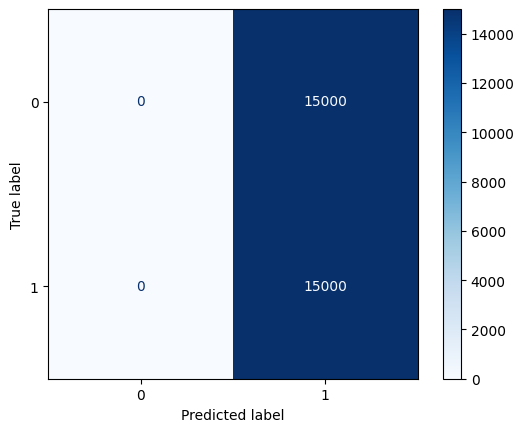

In [19]:
validate_model_bert(model, test_input, y_test)

In [20]:
my_reloaded_model = tf.keras.models.load_model(
       ('models/bert_kaggle_model.h5'),
       custom_objects={'KerasLayer': hub.KerasLayer}
)

# Other BERT

In [2]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [3]:
# split data
train_set, valid_set, test_set = stratified_split(df)
x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [4]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

params_dict = {'learning_rate': 2e-5,
                   'epochs': 3,
                   'batch': 16}

In [5]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [6]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

2024-05-07 04:23:39.582101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 04:23:39.583793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 04:23:39.607192: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [7]:
classifier_model = build_classifier_model()
classifier_model.summary()
#tf.keras.utils.plot_model(classifier_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [8]:
# steps_per_epoch = len(train_set)
# num_train_steps = steps_per_epoch * params_dict['epochs']
# num_warmup_steps = int(0.1*num_train_steps)

# optimizer = optimization.create_optimizer(init_lr=params_dict['learning_rate'],
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')

In [9]:
classifier_model.compile(optimizer=Adam(learning_rate=params_dict['learning_rate']),
                         loss=loss,
                         metrics=metrics)

In [10]:
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_valid, y_valid),
                               epochs=params_dict['epochs'])

Epoch 1/3


2813/2813 [==============================] - 9459s 3s/step - loss: 0.0975 - binary_accuracy: 0.9606 - val_loss: 0.0938 - val_binary_accuracy: 0.9701
Epoch 2/3
2813/2813 [==============================] - 9423s 3s/step - loss: 0.0267 - binary_accuracy: 0.9904 - val_loss: 0.0603 - val_binary_accuracy: 0.9813
Epoch 3/3
2813/2813 [==============================] - 9312s 3s/step - loss: 0.0134 - binary_accuracy: 0.9951 - val_loss: 0.2544 - val_binary_accuracy: 0.9560


In [11]:
classifier_model.save('models/bert_latest.h5')

/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
#reloaded = tf.keras.models.load_model(('models/test.h5'), custom_objects={'KerasLayer': hub.KerasLayer})

#### VALIDATION ####
938/938 [==============================] - 959s 1s/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15000
           1       0.92      1.00      0.96     15000

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



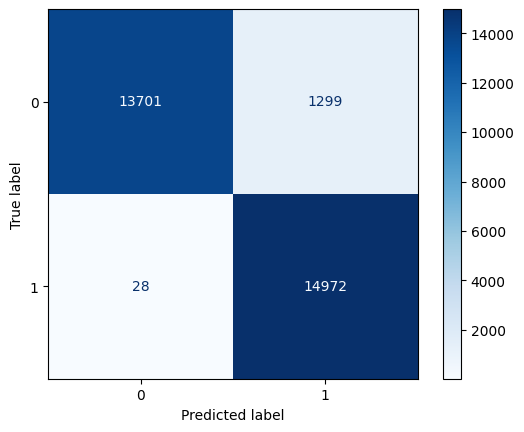

In [15]:
validate_model_bert(classifier_model, x_test, y_test)

# Predicting on Different Data

In [1]:
def get_extra_data(path):
    #load to df
    data = pd.read_pickle(path)
    data = pd.DataFrame({'text': data})
    # add labels
    labels = np.ones(data.shape[0])
    data['generated'] = labels
    return data

In [17]:
def predict_data(model, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    y = np.array(data['generated'])
    
    validate_model_bert(model, x, y)

#### VALIDATION ####
450/450 [==============================] - 503s 1s/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.06      0.11     14400

    accuracy                           0.06     14400
   macro avg       0.50      0.03      0.06     14400
weighted avg       1.00      0.06      0.11     14400



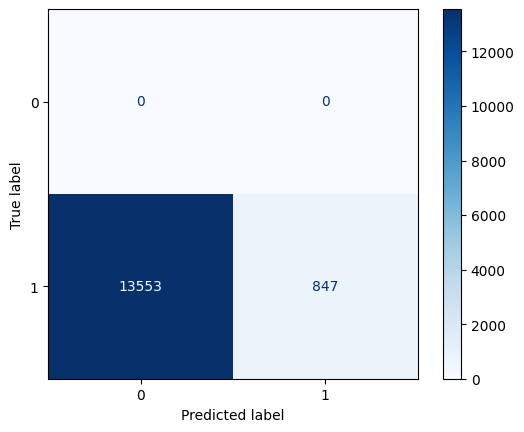

In [18]:
df_chatgpt = get_extra_data('data/extras/chat_gpt.pkl')
predict_data(classifier_model, df_chatgpt)

#### VALIDATION ####
450/450 [==============================] - 549s 1s/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.02      0.04     14400

    accuracy                           0.02     14400
   macro avg       0.50      0.01      0.02     14400
weighted avg       1.00      0.02      0.04     14400



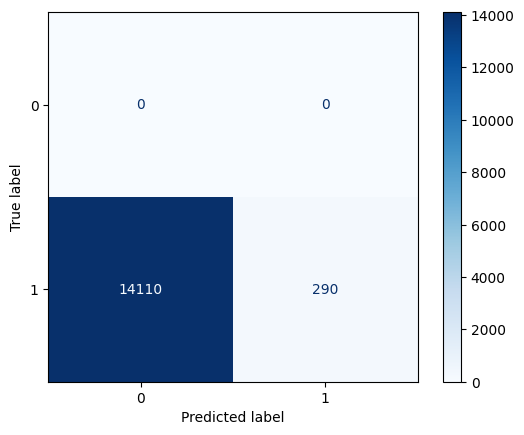

In [19]:
df_davinci = get_extra_data('data/extras/davinci.pkl')
predict_data(classifier_model, df_davinci)

#### VALIDATION ####
44/44 [==============================] - 47s 1s/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1375
           1       0.01      0.33      0.02         3

    accuracy                           0.94      1378
   macro avg       0.51      0.64      0.50      1378
weighted avg       1.00      0.94      0.97      1378



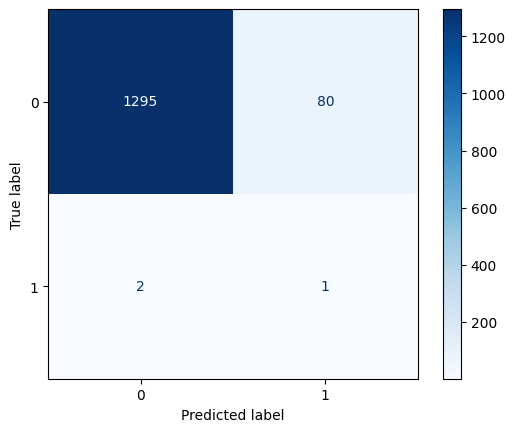

In [20]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(classifier_model, df_essays)

In [21]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 [==============================] - 115s 1s/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.81      0.89      3611

    accuracy                           0.81      3611
   macro avg       0.50      0.40      0.45      3611
weighted avg       1.00      0.81      0.89      3611



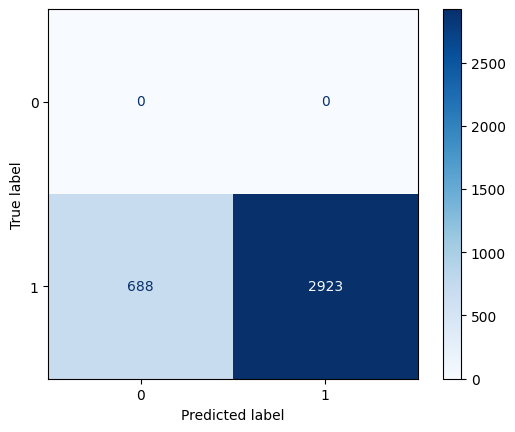

In [22]:
predict_data(classifier_model, df_extras)

#### VALIDATION ####
1056/1056 [==============================] - 1096s 1s/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.04      0.94      0.08      1375
         1.0       0.98      0.13      0.22     32414

    accuracy                           0.16     33789
   macro avg       0.51      0.53      0.15     33789
weighted avg       0.94      0.16      0.22     33789



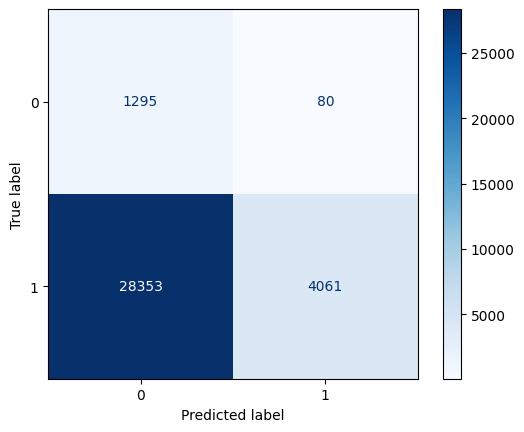

In [23]:
df_merged = pd.concat([df_extras, df_essays, df_chatgpt, df_davinci], axis=0)
predict_data(classifier_model, df_merged)

# BERT Shuffled

In [23]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [24]:
# split data
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [5]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

params_dict = {'learning_rate': 2e-5,
                   'epochs': 3,
                   'batch': 16}

In [6]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [8]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
optimizer = Adam(learning_rate=params_dict['learning_rate'])

In [9]:
classifier_model = build_classifier_model()
classifier_model.summary()
#tf.keras.utils.plot_model(classifier_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [10]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [14]:
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_valid, y_valid),
                               epochs=params_dict['epochs'])

Epoch 1/3
2813/2813 [==============================] - 9364s 3s/step - loss: 0.0950 - binary_accuracy: 0.9623 - val_loss: 0.0650 - val_binary_accuracy: 0.9788
Epoch 2/3
2813/2813 [==============================] - 9252s 3s/step - loss: 0.0253 - binary_accuracy: 0.9908 - val_loss: 0.1436 - val_binary_accuracy: 0.9596
Epoch 3/3
2813/2813 [==============================] - 9300s 3s/step - loss: 0.0134 - binary_accuracy: 0.9952 - val_loss: 0.1755 - val_binary_accuracy: 0.9562


In [15]:
classifier_model.save('models/bert_shuffled.h5')

/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### VALIDATION ####
938/938 [==============================] - 919s 979ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15000
           1       0.92      1.00      0.96     15000

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



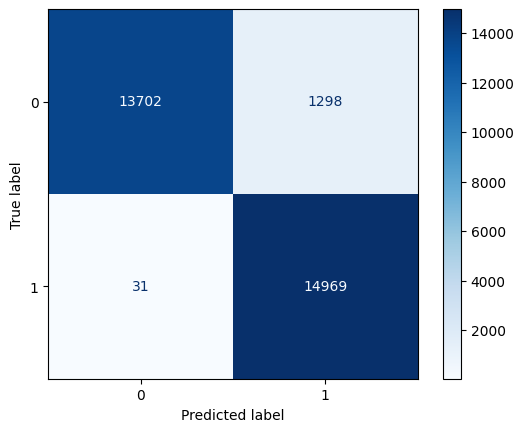

In [16]:
validate_model_bert(classifier_model, x_test, y_test)

In [19]:
def roc_score(model_name, y_true, y_pred_proba):
    """
    Plots the ROC curve for the given model and data. Calculates and prints the area under the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f'AUC: {auc}')
    plt.plot(fpr, tpr, label=model_name+" AUC="+str(round(auc, 3)))
    plt.legend(loc='best')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model_name}')
    plt.show()

In [21]:
reloaded_bert = tf.keras.models.load_model(('models/bert_shuffled.h5'), custom_objects={'KerasLayer': hub.KerasLayer})

2024-05-21 22:55:19.145708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:55:19.147836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:55:19.169561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

938/938 [==============================] - 1249s 1s/step
Accuracy:  0.9557
Recall:  0.9979333333333333
F1-score:  0.9574951226532766
AUC: 0.9990106044444444


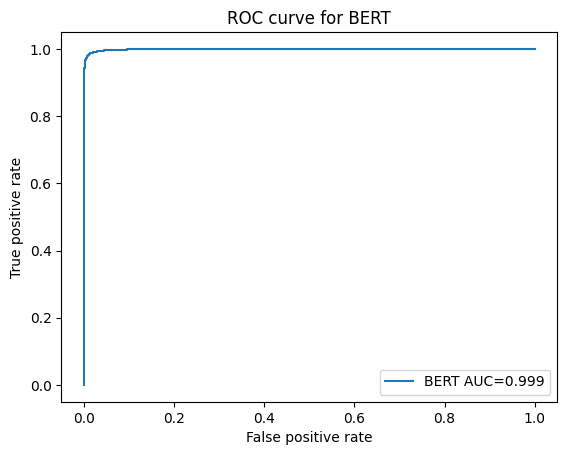

In [38]:
predictions_proba = reloaded_bert.predict(x_test)
predictions = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, predictions))
print('Recall: ', recall_score(y_test, predictions))
print('F1-score: ', f1_score(y_test, predictions))
roc_score('BERT', y_test, predictions_proba.flatten())

# Predicting on Different Data

In [18]:
def predict_data(model, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    y = np.array(data['generated'])
    
    validate_model_bert(model, x, y)

#### VALIDATION ####
44/44 [==============================] - 42s 963ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96      1375
           1       0.02      0.67      0.03         3

    accuracy                           0.91      1378
   macro avg       0.51      0.79      0.49      1378
weighted avg       1.00      0.91      0.95      1378



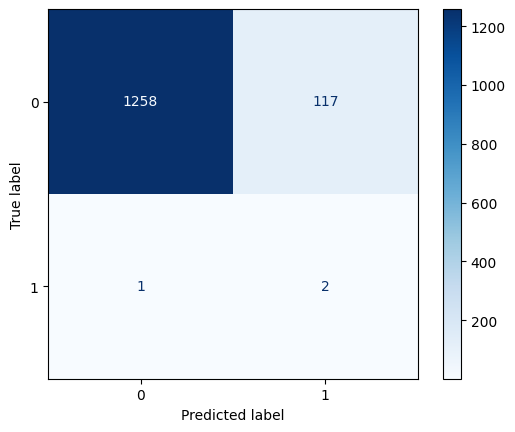

In [18]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(classifier_model, df_essays)

In [19]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 [==============================] - 111s 987ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.82      0.90      3611

    accuracy                           0.82      3611
   macro avg       0.50      0.41      0.45      3611
weighted avg       1.00      0.82      0.90      3611



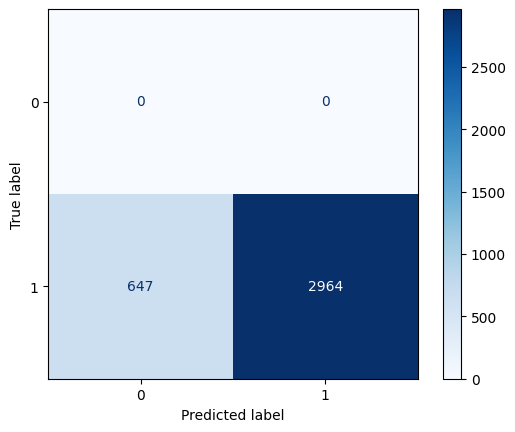

In [20]:
predict_data(classifier_model, df_extras)

# BERT activation funtion

In [3]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [4]:
# split data
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [5]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

params_dict = {'learning_rate': 2e-5,
                   'epochs': 3,
                   'batch': 16}

In [6]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()
optimizer = Adam(learning_rate=params_dict['learning_rate'])

In [13]:
classifier_model = build_classifier_model()
classifier_model.summary()
#tf.keras.utils.plot_model(classifier_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [15]:
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_valid, y_valid),
                               epochs=params_dict['epochs'])

classifier_model.save('models/bert_shuffled_sigmoid.h5')

Epoch 1/3
2813/2813 [==============================] - 9484s 3s/step - loss: 0.0929 - binary_accuracy: 0.9641 - val_loss: 0.1298 - val_binary_accuracy: 0.9508
Epoch 2/3
2813/2813 [==============================] - 9396s 3s/step - loss: 0.0241 - binary_accuracy: 0.9913 - val_loss: 0.1177 - val_binary_accuracy: 0.9576
Epoch 3/3
2813/2813 [==============================] - 9349s 3s/step - loss: 0.0129 - binary_accuracy: 0.9954 - val_loss: 0.2719 - val_binary_accuracy: 0.9274


/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### VALIDATION ####
938/938 [==============================] - 917s 978ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     15000
           1       0.87      1.00      0.93     15000

    accuracy                           0.93     30000
   macro avg       0.94      0.93      0.93     30000
weighted avg       0.94      0.93      0.93     30000



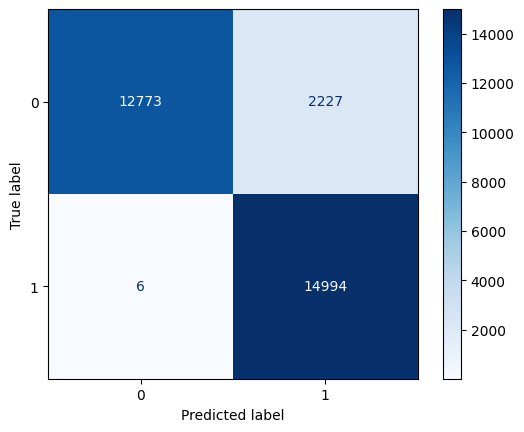

In [17]:
validate_model_bert(classifier_model, x_test, y_test)

938/938 [==============================] - 921s 982ms/step
Accuracy:  0.9255666666666666
Recall:  0.9996
F1-score:  0.9306973712796004
AUC: 0.9990835666666666


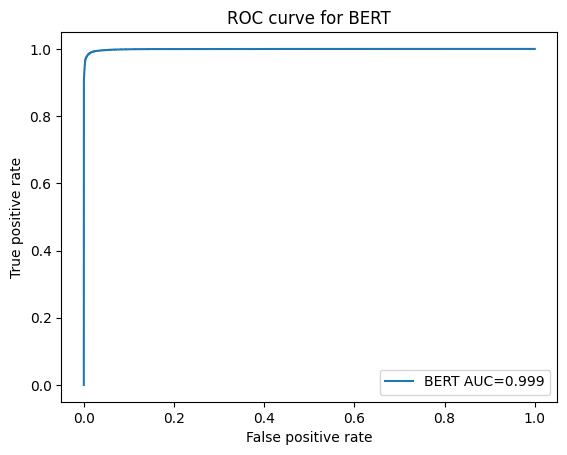

In [21]:
predictions_proba = classifier_model.predict(x_test)
predictions = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, predictions))
print('Recall: ', recall_score(y_test, predictions))
print('F1-score: ', f1_score(y_test, predictions))
roc_score('BERT', y_test, predictions_proba.flatten())

#### VALIDATION ####
44/44 [==============================] - 42s 960ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      1375
           1       0.00      1.00      0.01         3

    accuracy                           0.43      1378
   macro avg       0.50      0.71      0.30      1378
weighted avg       1.00      0.43      0.60      1378



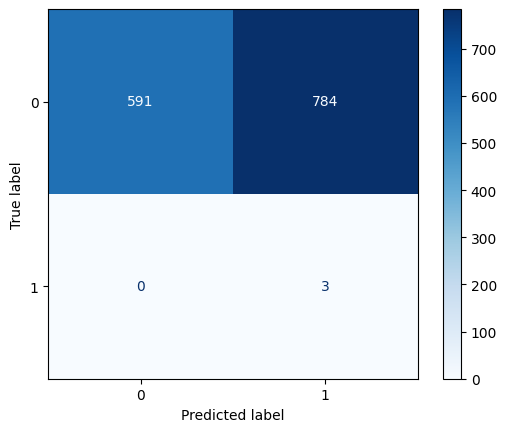

In [22]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(classifier_model, df_essays)

In [23]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 [==============================] - 112s 988ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.99      0.99      3611

    accuracy                           0.99      3611
   macro avg       0.50      0.49      0.50      3611
weighted avg       1.00      0.99      0.99      3611



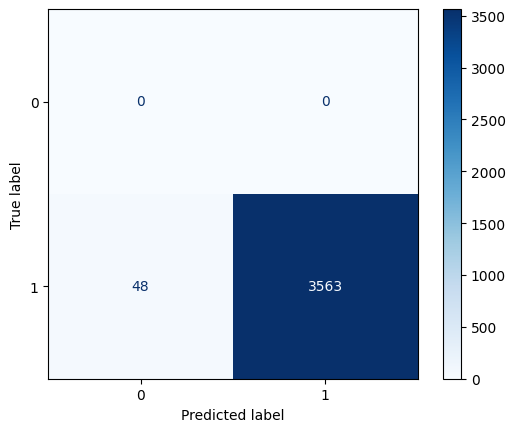

In [24]:
predict_data(classifier_model, df_extras)